# Computing the mean using `Pipe`

In this notebook, we compute the mean of an array of random numbers.  

Rather than import NumPy, we will use the `%pylab` magic command, which essentially is equivalent

    from numpy import *
    from scipy import *
    from matplotlib.pyplot import *
    
**Note:**  To use this notebook, you will need to install the Pandas package.  

    $ pip install pandas
    
or 

    $ sudo pip install pandas
    

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [9]:
import time
import multiprocessing as mp
import pandas

### Create an large array of random numbers

In [3]:
N = 2**28
x = random.rand(N)
print("Memory = {:.4f} (MB)".format(8*N/1024**2))

memory = 2048.0000 (MB)


### Write a function that computes the mean of the array of values

In [7]:
def vector_sum(x,cpipe):    
    s = sum(x)
    cpipe.send(s)
    
def compute_mean(x,np):
    N = len(x)
    jobs = []
    pp = []
    for i in range(np):
        ppipe, cpipe = mp.Pipe(duplex=False)   # Duplex=True is default
        i1 = int(i*N/np)
        i2 = int((i+1)*N/np)
        
        job = mp.Process(target=vsum,args=(x[i1:i2],cpipe))
        pp.append(ppipe)
        jobs.append(job)
        
    for job in jobs:
        job.start()
    
    for job in jobs:
        job.join()

    s = 0
    for p in pp:
        s += p.recv()     
        
    return s/N    

### Verify results
Let's check that our parallel results are correct by comparing with the Numpy routine `mean`.  At the same time, we can time the results to see how the parallel compares to an optimized serial code. 

In [13]:
%time a1 = compute_mean(x,8)
print("a1 = {:24.16f}".format(a1))
print("")

%time a2 = mean(x)
print("a2 = {:24.16f}".format(a2))

CPU times: user 11.6 ms, sys: 28.1 ms, total: 39.7 ms
Wall time: 317 ms
a1 =       0.5000292384437462

CPU times: user 319 ms, sys: 3.1 ms, total: 323 ms
Wall time: 325 ms
a2 =       0.5000292384437445


### Test the scalability
Lets collect timing data for a range of processor counts so that we can see if we are getting good "scalabilty" and "speed-up". 

What is "speed-up"?  The speed-up $S_p$ on $p$ processors is the ratio of time on a single processor to the time on $p$ processors. 

\begin{equation*}
S_p = \frac{T_0}{T_p}
\end{equation*}

Perfect speed-up is $S_p = p$.  

A related measure is "efficiency".  This is the ratio of actual speed-up to expected speed-up. 

\begin{equation*}
E_p = \frac{S_p}{p}
\end{equation*}

Efficiency is often expressed as a percentage.  Perfect efficiency is then 100%. 

In [11]:
# Use 'timeit' loop (see 'using_timeit' notebook.)
procs = 2**arange(0,6)
tdata = empty(procs.shape)
for i,np in enumerate(procs):
    tr = %timeit -n 1 -r 5 -q -o pass; compute_mean(x,np)
    tdata[i] = tr.best    

### Create a Pandas Data Frame to store the data

In [16]:
p = pandas.Series(procs)  # 'd' is type "double"
t = pandas.Series(tdata)
df = pandas.DataFrame({'Procs' : p, 'Time' : t})

fstr = {'Procs' : "{:d}".format, 'Time' : "{:.2f}".format}
df.style.format(fstr)

,Procs,Time
0,1,1.23
1,2,0.68
2,4,0.41
3,8,0.28
4,16,0.30
5,32,0.33


## Plot strong scaling results
We will use Pylab commands (which look very much like Matlab commands) to plot the strong scaling results. 

<IPython.core.display.Javascript object>


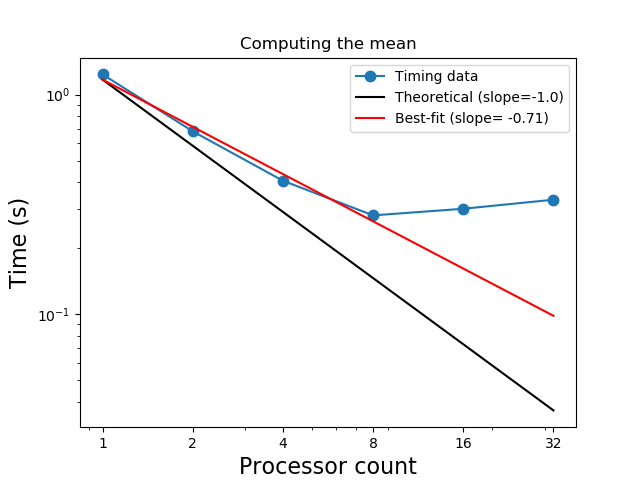

In [22]:
loglog(df['Procs'],df['Time'],'.-',markersize=15,label='Timing data')

xlabel('Processor count',fontsize=16)
ylabel('Time (s)',fontsize=16)
title('Computing the mean');

### Best-fit line to data frame

In [24]:
t_strong = df['Time'].values
c = polyfit(log(procs[:4]),log(t_strong[:4]),1)
loglog(procs,exp(polyval(c,log(procs))),'r-',label='Best-fit (slope={:6.2f})'.format(c[0]))

Add the theoretical slope for comparison

In [23]:
c[0] = -1
loglog(procs,exp(polyval(c,log(procs))),'k-',label='Theoretical (slope=-1.0)')

Add a legend and fix the xticks. 

In [25]:
legend()

# Make nice tick marks
pstr = (['{:d}'.format(int(p)) for p in procs])
xticks(procs,pstr);